In [1]:
from requests import get
from json import dumps
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import datetime
import pyswarms as ps
from pyswarms.single.global_best import GlobalBestPSO
import scipy

In [2]:
def N_avg(a, N=7):
    # weekly avg into the past
    b = np.zeros(len(a)-N)
    for i in range(N,len(a),1):
        b[i-N] = np.mean(a[i-N:i])
    return b

def N_avg_preserve(a):
    # hard edged rolling weekly average, preserve len(a) by nan-ing
    b = np.zeros(len(a))
    b[:] = np.nan
    for i in range(3,len(a)-4,1):
        b[i] = np.mean(a[i-4+1:i+3+1])
    return b    

def diff_axis(scale, ax1, ax2):
    _,l1 = ax1.get_ylim()
    _,l2 = ax2.get_ylim()
    d1 = np.array(ax1.lines[0].get_ydata())
    d2 = np.array(ax2.lines[0].get_ydata())
    return np.mean(np.abs(d1/scale-d2))
    
def match_axis(ax1, ax2):
    scale = scipy.optimize.minimize(diff_axis, 1, args=(ax1,ax2))
    _,l2 = ax2.get_ylim()
    ax1.set_ylim(0,l2*scale.x)  
    return scale.x

In [3]:
# download api data for England
req = "https://api.coronavirus.data.gov.uk/v2/data?areaType=nation&areaCode=E92000001&metric=newAdmissions&metric=newCasesBySpecimenDate&format=json"
response = get(req, timeout=10)
if response.status_code >= 400:
    raise RuntimeError(f'Request failed: { response.text }')
response = response.json()

df_england = pd.DataFrame(response['body'])
df_england['dateTime'] = pd.to_datetime(df_england['date'])
df_england.sort_values(by=['dateTime'], inplace=True)
df_england.dropna(inplace=True)

top_date = sorted(list(set(df_england.dateTime.to_list())))[-1].strftime("%Y-%m-%d")
print(top_date)

2021-12-22


In [4]:
# download api data for regions 
req = "https://api.coronavirus.data.gov.uk/v2/data?areaType=region&metric=newCasesBySpecimenDate&format=json"
response = get(req, timeout=10)
if response.status_code >= 400:
    raise RuntimeError(f'Request failed: { response.text }')
response = response.json()

df_regions_cases = pd.DataFrame(response['body'])
df_regions_cases['dateTime'] = pd.to_datetime(df_regions_cases['date'])
df_regions_cases.sort_values(by=['dateTime'], inplace=True)
df_regions_cases.dropna(inplace=True)

top_date_cases = sorted(list(set(df_regions_cases.dateTime.to_list())))[-1].strftime("%Y-%m-%d")
print(top_date_cases)

req = "https://api.coronavirus.data.gov.uk/v2/data?areaType=nhsRegion&metric=newAdmissions&format=json"
response = get(req, timeout=10)
if response.status_code >= 400:
    raise RuntimeError(f'Request failed: { response.text }')
response = response.json()

df_regions_nhs = pd.DataFrame(response['body'])
df_regions_nhs['dateTime'] = pd.to_datetime(df_regions_nhs['date'])
df_regions_nhs.sort_values(by=['dateTime'], inplace=True)
df_regions_nhs.dropna(inplace=True)

top_date_nhs = sorted(list(set(df_regions_nhs.dateTime.to_list())))[-1].strftime("%Y-%m-%d")
print(top_date_nhs)

top_date = min(top_date_cases, top_date_nhs)

2021-12-23
2021-12-22


In [5]:
# input defs
train_in_stream = []
train_out_stream = []
dates_train = []
test_in_stream = []
test_out_stream = []
dates_test = []

in_event = ""
out_event = ""
geographical_context = ""

train_start_date = "2020-11-15" 
train_end_date = "2021-03-01"
test_start_date = "2021-04-01"
test_end_date = top_date

In [6]:
# set data: England +ve tests -> hosp admissions
df = df_england
train_df = df[(df.dateTime >= train_start_date) & (df.dateTime <= train_end_date)]
test_df = df[(df.dateTime >= test_start_date) & (df.dateTime <= test_end_date)]

train_in_stream = np.array(train_df.newCasesBySpecimenDate.to_list(), dtype=float)
train_out_stream = np.array(train_df.newAdmissions.to_list(), dtype=float)
test_in_stream = np.array(test_df.newCasesBySpecimenDate.to_list(), dtype=float)
test_out_stream = np.array(test_df.newAdmissions.to_list(), dtype=float)
dates_train = sorted(list(set(train_df.dateTime.to_list())))
dates_test = sorted(list(set(test_df.dateTime.to_list())))

#train_in_stream = N_avg(train_in_stream)
#train_out_stream = N_avg(train_out_stream)
#test_in_stream = N_avg(test_in_stream)
#test_out_stream = N_avg(test_out_stream)

in_event = "+ve test"
out_event = "admitted"
geographical_context = "England"

In [7]:
# set data: Regional +ve tests -> hosp admissions
region = "London"
df_c = df_regions_cases[df_regions_cases.areaName==region]
df_n = df_regions_nhs[df_regions_nhs.areaName==region]

train_df_c = df_c[(df_c.dateTime >= train_start_date) & (df_c.dateTime <= train_end_date)]
train_df_n = df_n[(df_n.dateTime >= train_start_date) & (df_n.dateTime <= train_end_date)]
test_df_c = df_c[(df_c.dateTime >= test_start_date) & (df_c.dateTime <= test_end_date)]
test_df_n = df_n[(df_n.dateTime >= test_start_date) & (df_n.dateTime <= test_end_date)]

train_in_stream = np.array(train_df_c.newCasesBySpecimenDate.to_list(), dtype=float)
train_out_stream = np.array(train_df_n.newAdmissions.to_list(), dtype=float)
test_in_stream = np.array(test_df_c.newCasesBySpecimenDate.to_list(), dtype=float)
test_out_stream = np.array(test_df_n.newAdmissions.to_list(), dtype=float)
dates_train = sorted(list(set(train_df_c.dateTime.to_list())))
dates_test = sorted(list(set(test_df_c.dateTime.to_list())))

#train_in_stream = N_avg(train_in_stream)
#train_out_stream = N_avg(train_out_stream)
#test_in_stream = N_avg(test_in_stream)
#test_out_stream = N_avg(test_out_stream)

in_event = "+ve test"
out_event = "admitted"
geographical_context = region

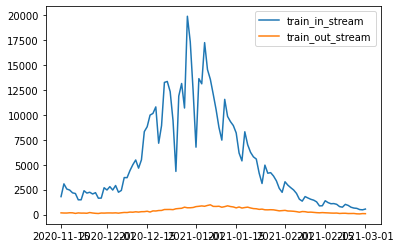

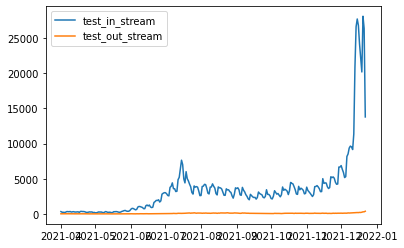

In [9]:
plt.clf()
plt.plot(dates_train, train_in_stream, label="train_in_stream")
plt.plot(dates_train, train_out_stream, label="train_out_stream")
plt.legend()
plt.show()
plt.clf()
plt.plot(dates_test, test_in_stream, label="test_in_stream")
plt.plot(dates_test, test_out_stream, label="test_out_stream")
plt.legend()
plt.show()

In [11]:
def _f(x, in_stream, out_stream):
    # model out_stream as a convolution of in_stream with x
    target_out_stream = out_stream[len(x)-1:]  ## remove the first values that are shorter than the kernel
    pred_out_stream = np.convolve(in_stream, x, mode="valid")
    return target_out_stream, pred_out_stream

def f(xs, in_stream=train_in_stream, out_stream=train_out_stream):
    ret = np.zeros(np.shape(xs)[0])
    for i in range(len(ret)):
        x = xs[i,:]
        target_out_stream, pred_out_stream = _f(x, in_stream, out_stream)
        ret[i] = np.sum(np.abs(pred_out_stream - target_out_stream)) / len(pred_out_stream)
    return ret        

In [14]:
n_dim = 40  ## this is the max number of day allowed to convert from case to hospitalisation
n_particles = 1000

x_max = 0.03*np.ones(n_dim)
x_min = -0.005*np.ones(n_dim)
options = {'c1': 0.5, 'c2': 0.2, 'w': 0.5}
bounds = (x_min, x_max)
init_pos = np.array([np.zeros(n_dim) for i in range(n_particles)])

_minimizers = []

for i in range(20):
    optimizer = GlobalBestPSO(n_particles=n_particles, dimensions=n_dim, options=options, bounds=bounds, init_pos=init_pos)
    cost, pos = optimizer.optimize(f, 1000, verbose=True)
    _minimizers.append(pos)
minimizers = np.array(_minimizers)

2021-12-27 12:25:11,624 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.2, 'w': 0.5}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=24.2
2021-12-27 12:25:26,633 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 24.169392043105855, best pos: [ 0.00325124  0.00225429  0.00580415  0.00492402  0.00308926  0.00663743
  0.00625381  0.00371588  0.00738521 -0.00040569  0.00554549  0.00250695
 -0.00118498  0.00421172  0.0036571   0.00279459  0.001106    0.00183831
 -0.00098808  0.00169682  0.00168711  0.00027351 -0.00045167 -0.00041318
  0.00126575 -0.00064107 -0.00132673 -0.0009964   0.00329085  0.00026108
 -0.00017721 -0.00039446 -0.00072399  0.00189769  0.00137955 -0.00104739
  0.00094023  0.00171084 -0.0016132   0.00161137]
2021-12-27 12:25:26,706 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.2, 'w': 0.5}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_co

2021-12-27 12:27:25,579 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.2, 'w': 0.5}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=21.8
2021-12-27 12:27:40,457 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 21.79397615836454, best pos: [ 0.00543186  0.00183308  0.00654515  0.00260567  0.00486419  0.007226
  0.00854706  0.00466195  0.00273935  0.0046898   0.00369725 -0.00080917
  0.0003011  -0.00139889  0.00834947 -0.00197994  0.00289199  0.00063649
 -0.0002076   0.00101952  0.00191883  0.00229096 -0.00102626 -0.00070053
 -0.00029275 -0.00054706 -0.00045364  0.00113821 -0.00071132  0.00162632
  0.00325687 -0.00123686  0.00305563 -0.00048402  0.00028325  0.00188068
 -0.00072199 -0.00153705 -0.000859    0.00251861]
2021-12-27 12:27:40,518 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.2, 'w': 0.5}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=

2021-12-27 12:29:39,460 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.2, 'w': 0.5}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=21.6
2021-12-27 12:29:54,379 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 21.608329032212346, best pos: [ 2.68220639e-03  2.76603206e-03  7.42462931e-03  3.04985706e-03
  5.07351524e-03  4.23967477e-03  8.22607558e-03  1.36905314e-02
 -1.21453453e-03  7.41224781e-05  4.97215860e-03  4.40050987e-04
  2.35621054e-03  5.12354374e-04  1.65261476e-03 -7.97584519e-04
 -1.12055709e-04  8.21720205e-03 -2.23806807e-03 -1.80893995e-03
  5.42194469e-03  3.29232017e-03 -1.53014129e-03  1.84302762e-03
 -1.45015250e-03 -9.71404226e-04 -7.47146449e-04  1.61716756e-03
 -1.02892174e-03  1.17011546e-03  5.01768346e-04 -2.26083567e-04
  1.78090511e-03 -4.15576011e-05  4.45408735e-04  1.45324807e-03
 -8.68863531e-04  3.28629583e-03 -2.20730655e-03 -2.05505314e-04]
2021-12-27 12:29:54,444 -

(20, 40)


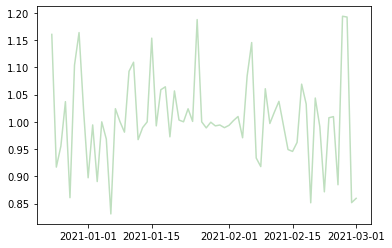

In [101]:
print(minimizers.shape)

my_kernel = minimizers[3]  ## take the first proposed kernel

my_pred_out_stream = np.convolve(train_in_stream, my_kernel, mode="valid")
clean_truth = train_out_stream[-len(my_pred_out_stream):]  ## removes the out of predicted range data

plt.clf()
plt.plot(dates_train[-len(my_pred_out_stream):], my_pred_out_stream/clean_truth, color="green", alpha=0.25)
plt.show()


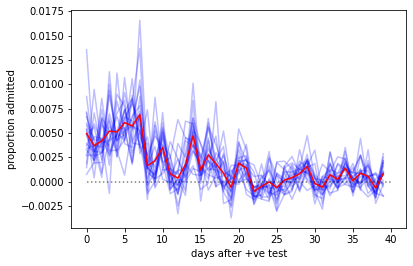

68


<Figure size 432x288 with 0 Axes>

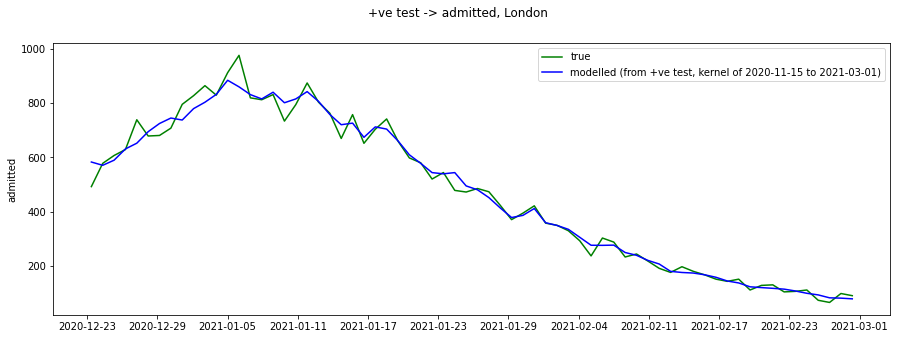

<Figure size 432x288 with 0 Axes>

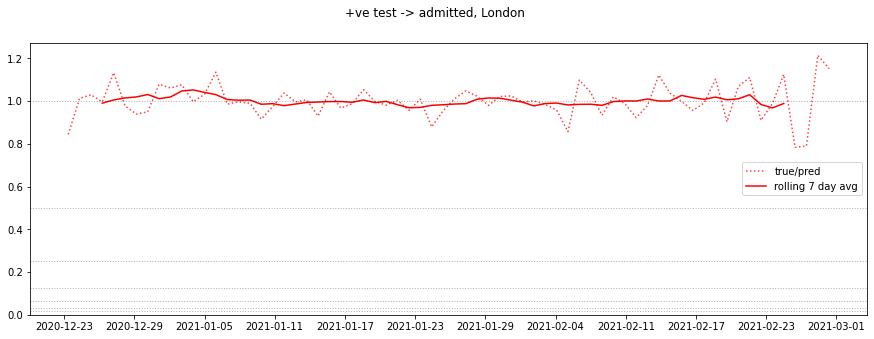

227


<Figure size 432x288 with 0 Axes>

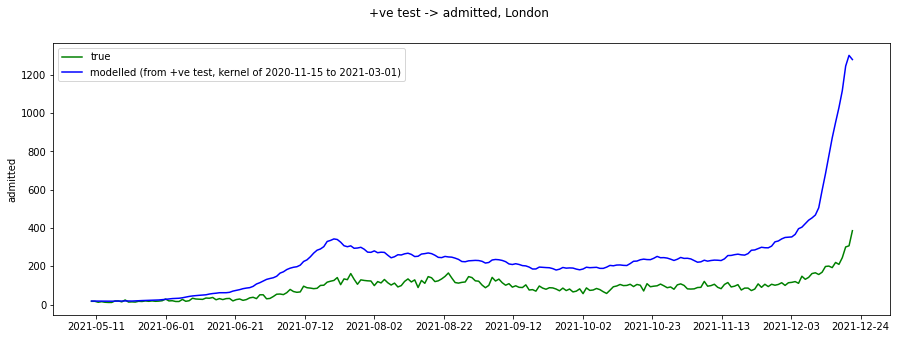

<Figure size 432x288 with 0 Axes>

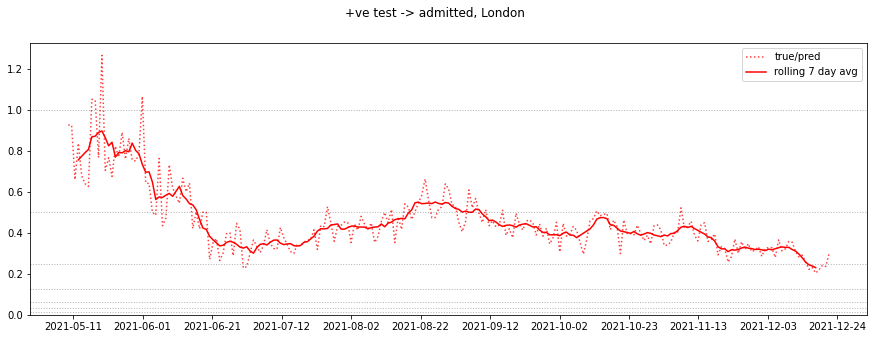

In [75]:
# show kernel
plt.clf()
z = list(range(len(pos)))
for y in minimizers:
    plt.plot(z, y, color="blue", alpha=0.25)
avg_minimizer = []
for i in range(len(minimizers[0])):
    avg_minimizer.append(np.mean(minimizers[:,i]))
avg_minimizer = np.array(avg_minimizer)
plt.plot(z, avg_minimizer, color="red", alpha=1)
plt.xlabel("days after %s" % in_event)
plt.ylabel("proportion %s" % out_event)
plt.hlines(0, 0,len(z), ls="dotted", alpha=0.5, color="black")
plt.savefig("%s__%s__kernel__%s.png" % (in_event, out_event, geographical_context), bbox_inches='tight', facecolor='white', transparent=False)
plt.show()

#print("mass: %.2f" % np.sum(avg_minimizer))

# show fit to training & testing
def make_graph(dates, kernel, in_stream, out_stream, test_train):
    plt.clf()
    assert(len(in_stream)==len(out_stream))
    assert(len(kernel)<=len(in_stream))
    true, pred = _f(avg_minimizer, in_stream, out_stream) 
    x = dates[-len(true):]
    fig, ax1 = plt.subplots(1,1, figsize=(15,5))
    ax1.plot(x, true, color="green", label="true")
    ax1.plot(x, pred, color="blue", label="modelled (from %s, kernel of %s to %s)" % (in_event, train_start_date, train_end_date))
    ax1.set_ylabel("%s" % out_event)
    ax1.legend()
    ax = plt.gca()
    n_marks = 11
    ax.xaxis.set_major_locator(ticker.MultipleLocator(len(x)/n_marks))
    fig.suptitle("%s -> %s, %s" % (in_event, out_event, geographical_context))
    plt.savefig("%s__%s__%s__%s.png" % (in_event, out_event, test_train, geographical_context), bbox_inches='tight', facecolor='white', transparent=False)
    plt.show()
    
    plt.clf()
    fig, ax1 = plt.subplots(1,1, figsize=(15,5))
    plt.plot(x, true/pred, color="red", alpha=0.75, ls="dotted", label="true/pred")
    plt.plot(x, N_avg_preserve(true/pred), color="red", label="rolling 7 day avg")
    #plt.axhline(y=(true/pred)[-1], ls="dashed", lw=1, alpha=0.3, color="black")
    for i in range(7):
        plt.axhline(y=2**(-i), ls="dotted", lw=1, alpha=0.3, color="black")        
    plt.ylim(0,None)
    plt.legend()
    ax = plt.gca()
    ax.xaxis.set_major_locator(ticker.MultipleLocator(len(x)/n_marks))
    fig.suptitle("%s -> %s, %s" % (in_event, out_event, geographical_context))
    plt.savefig("%s__%s__%s__%s__ratio.png" % (in_event, out_event, test_train, geographical_context), bbox_inches='tight', facecolor='white', transparent=False)
    plt.show()
    
make_graph(dates_train, avg_minimizer, train_in_stream, train_out_stream, "train") 
make_graph(dates_test, avg_minimizer, test_in_stream, test_out_stream, "test") 




In [48]:
print(avg_minimizer)

[ 4.95621687e-03  3.71133402e-03  4.20289970e-03  5.19597724e-03
  5.12343415e-03  6.06666390e-03  5.74118818e-03  6.89176312e-03
  1.65250231e-03  2.17129259e-03  3.52346574e-03  8.31580048e-04
  3.81077923e-04  1.77504997e-03  4.72882071e-03  1.21173700e-03
  2.76692154e-03  1.86945463e-03  8.82294143e-04 -5.53153299e-04
  1.90954722e-03  1.40885457e-03 -9.72186879e-04 -4.57213217e-04
 -5.16510284e-06 -5.92366146e-04  1.75581004e-04  4.29143308e-04
  8.25481150e-04  1.60498875e-03 -1.74727543e-04 -5.42619351e-04
  7.25857912e-04  2.59350604e-04  1.40726452e-03  1.03266073e-04
  8.83950168e-04  5.66227403e-04 -6.41661660e-04  8.42043525e-04]
